# Import packages

In [6]:
import textwrap
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
import colorednoise as cn
import seaborn as sns
import scipy.fft as spfft
from matplotlib import mlab

In [7]:
import sys
sys.path.append("..")
from AdvEMDpy import EMD
from emd_basis import Basis
from emd_preprocess import Preprocess
from emd_hilbert import hilbert_spectrum

In [8]:
sns.set(style='darkgrid')
np.random.seed(0)

# Full-Spectrum Ensemble Empirical Mode Decomposition (FSEEMD)

# Prepare various Colours of Noise

In [9]:
n = 1001
time = np.linspace(0, 5 * np.pi, n)
time_series = np.cos(time) + np.cos(5 * time) + np.random.normal(0, 1, len(time))
preprocess = Preprocess(time=time, time_series=time_series)
median = preprocess.median_filter()[1]
sd_time_series = np.std(time_series-median)

x_points = [0, (np.pi / 2), np.pi, (3 * np.pi / 2), 2 * np.pi, (5 * np.pi / 2),
            3 * np.pi, (7 * np.pi / 2), 4 * np.pi, (9 * np.pi / 2), 5 * np.pi]
x_names = (r'$ 0 $', r'$ \dfrac{\pi}{2} $', r'$ \pi $', r'$ \dfrac{3\pi}{2} $', r'$ 2\pi $', r'$ \dfrac{5\pi}{2} $',
           r'$ 3\pi $', r'$ \dfrac{7\pi}{2} $', r'$ 4\pi $', r'$ \dfrac{9\pi}{2} $', r'$ 5\pi $')


number_of_samples = np.shape(time)[0]

colour_dict = {}
colour_dict[-2] = 'Violet'
colour_dict[-1] = 'Blue'
colour_dict[0] = 'White'
colour_dict[1] = 'Pink'
colour_dict[2] = 'Brown'

# Plot Power Spectral Density and Noise Examples

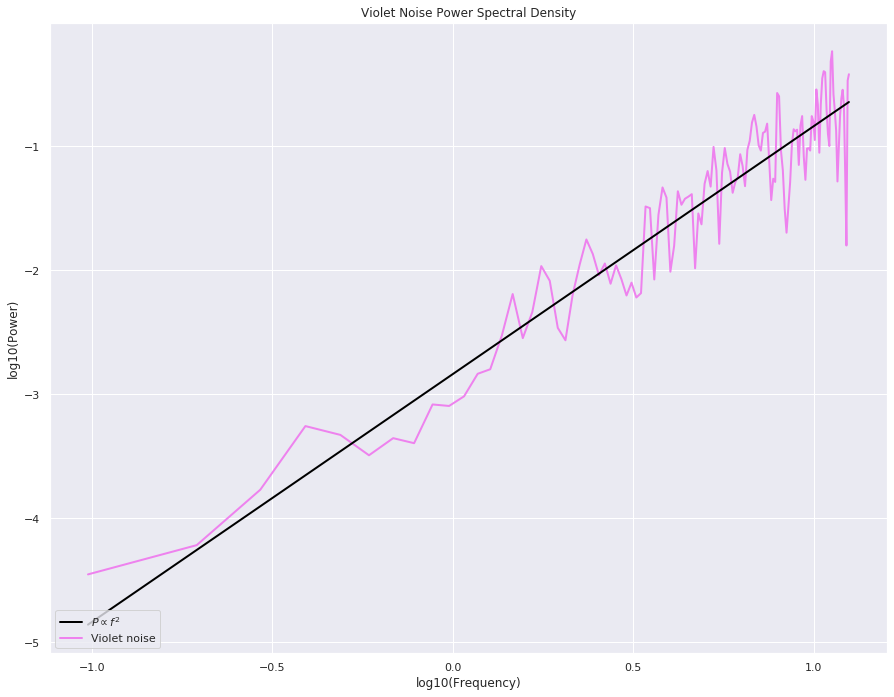

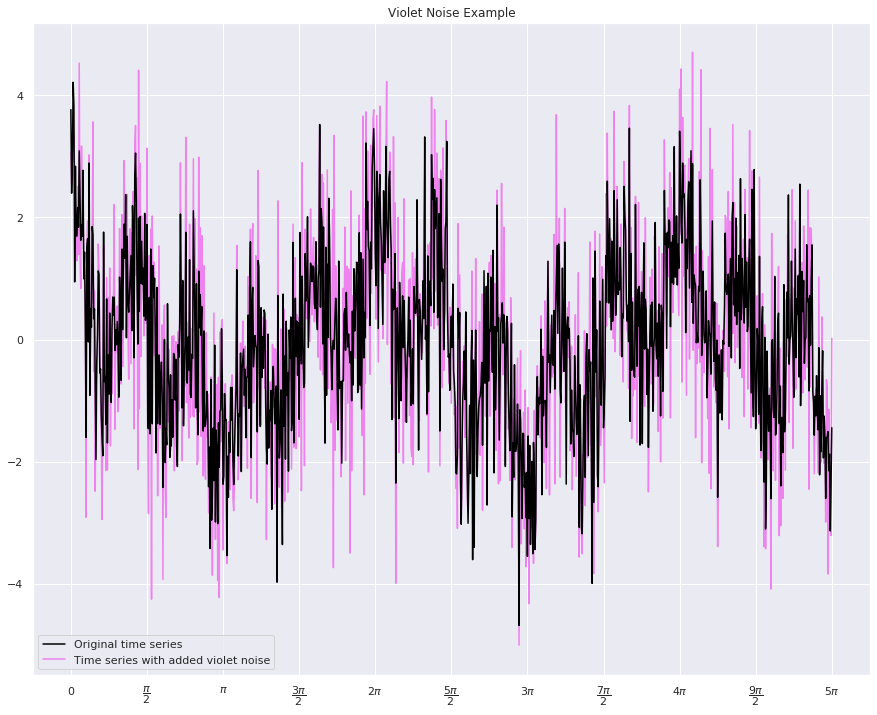

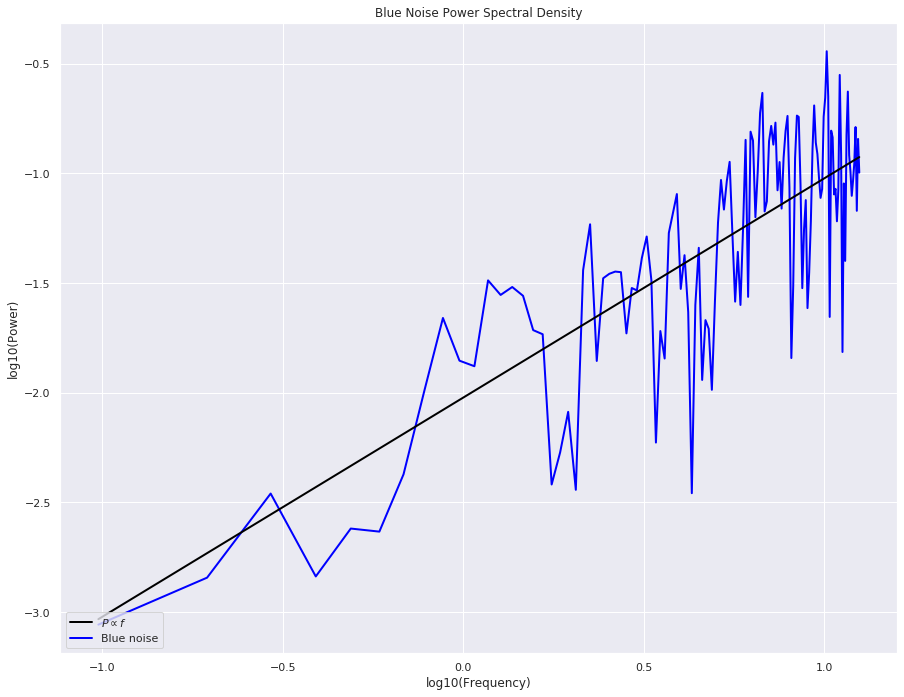

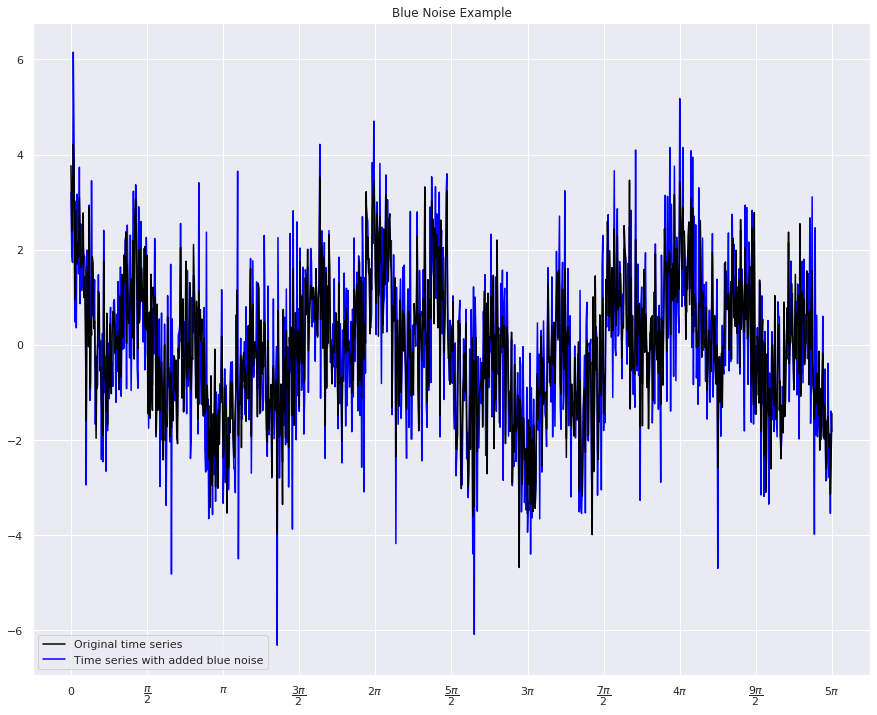

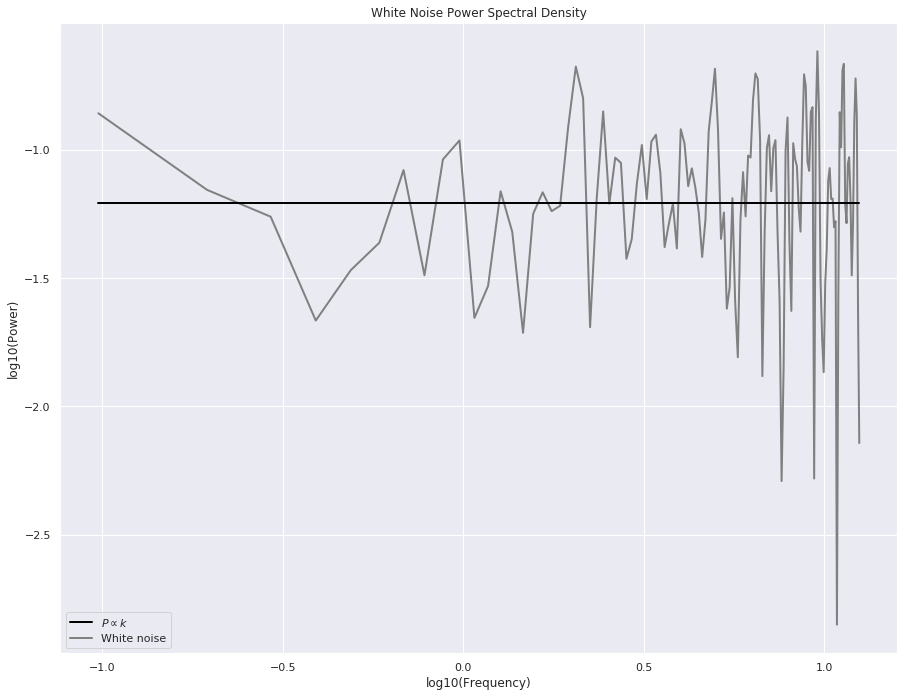

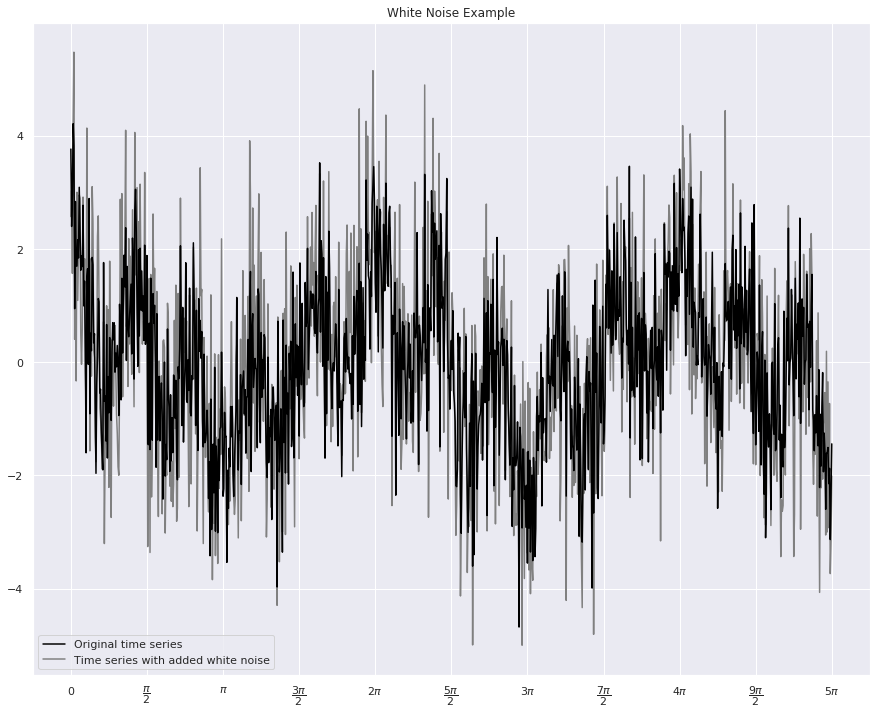

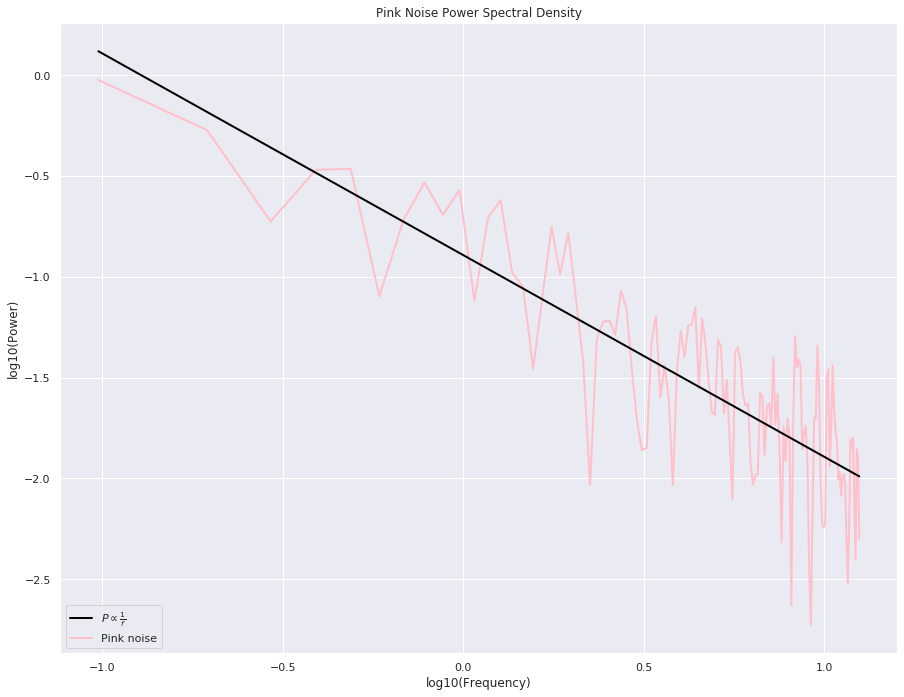

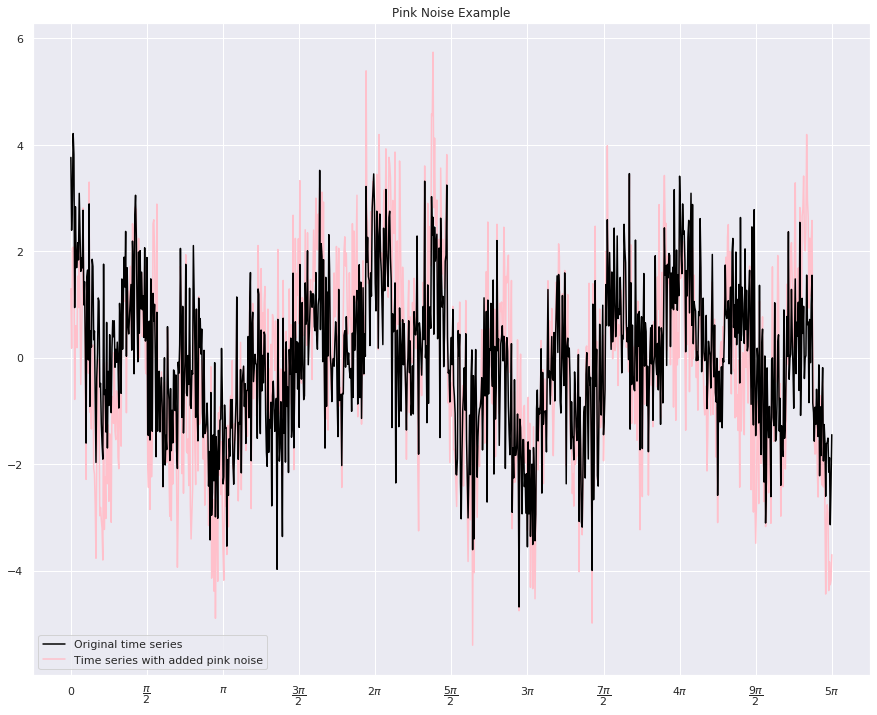

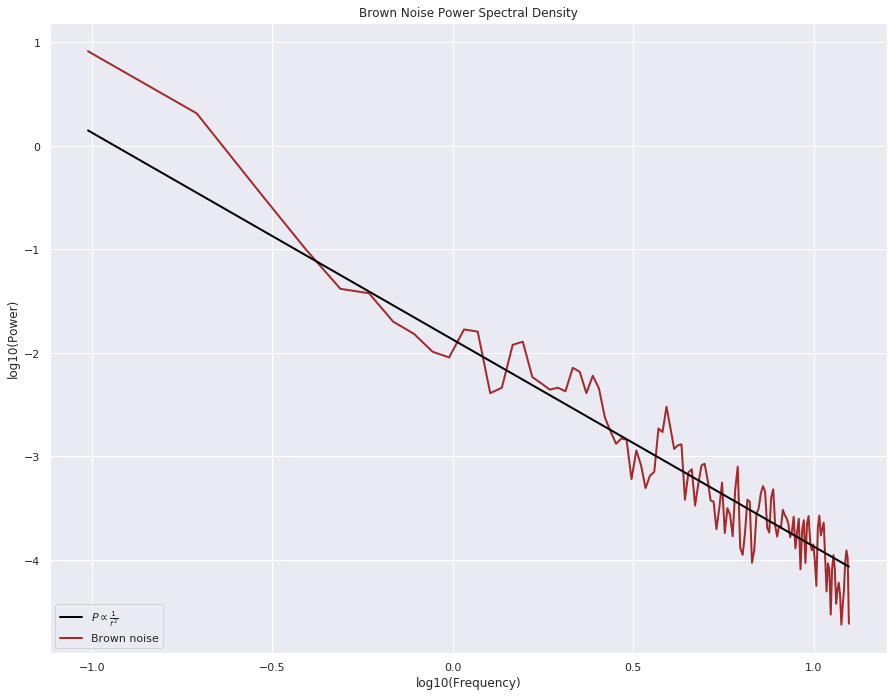

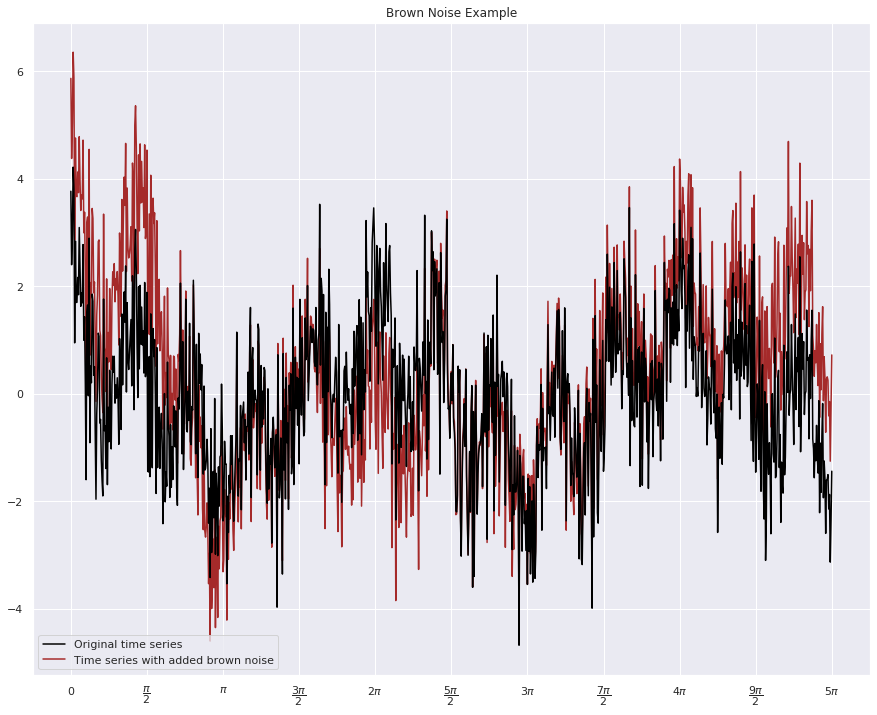

In [11]:
for beta in colour_dict.keys():

    noise = cn.powerlaw_psd_gaussian(beta, number_of_samples)
    dt = 0.04
    s, f = mlab.psd(noise, Fs=1 / dt)
    plt.gcf().subplots_adjust(bottom=0.15)
    if beta == 2:
        plt.plot(np.log10(f), np.log10((1 / f) ** 2) - np.mean(np.log10((1 / f)[1:] ** 2) - np.log10(s)[1:]),
                 color='black', label=r'$P \propto \frac{1}{f^2}$ ', Linewidth=2, zorder=2)
    elif beta == 1:
        plt.plot(np.log10(f), np.log10(1 / f) - np.mean(np.log10(1 / f)[1:] - np.log10(s)[1:]),
                 color='black', label=r'$P \propto \frac{1}{f}$ ', Linewidth=2, zorder=2)
    elif beta == 0:
        plt.plot(np.log10(f), np.ones_like(f) - np.mean(np.ones_like(f)[1:] - np.log10(s)[1:]),
                 color='black', label=r'$P \propto k$ ', Linewidth=2, zorder=2)
    elif beta == -1:
        plt.plot(np.log10(f), np.log10(f) - np.mean(np.log10(f)[1:] - np.log10(s)[1:]),
                 color='black', label=r'$P \propto f$ ', Linewidth=2, zorder=2)
    elif beta == -2:
        plt.plot(np.log10(f), np.log10(f ** 2) - np.mean(np.log10(f ** 2)[1:] - np.log10(s)[1:]),
                 color='black', label=r'$P \propto f^2$ ', Linewidth=2, zorder=2)
    if beta != 0:
        colour = colour_dict[beta]
    else:
        colour = 'Grey'
    plt.plot(np.log10(f), np.log10(s), color=f'{colour}', label=f'{colour_dict[beta]} noise', Linewidth=2, zorder=1)
    plt.legend(loc='lower left')
    plt.title(f'{colour_dict[beta]} Noise Power Spectral Density')
    plt.xlabel('log10(Frequency)')
    plt.ylabel('log10(Power)')
    plt.show()

    noisy_time_series = time_series + noise
    plt.title(f'{colour_dict[beta]} Noise Example')
    if beta != 0:
        colour = colour_dict[beta]
    else:
        colour = 'Grey'
    plt.plot(time, time_series, '-', c='black', label='Original time series', zorder=2)
    plt.plot(time, noisy_time_series, c=f'{colour}', label=f'Time series with added {colour_dict[beta].lower()} noise',
             zorder=1)
    plt.xticks(x_points, x_names)
    plt.legend(loc='lower left')
    plt.rcParams['figure.figsize'] = [15, 12]
    plt.show()

# Test FSEEMD

/home/cole/miniconda3/envs/emd/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(-2, 2 + 1) instead
  


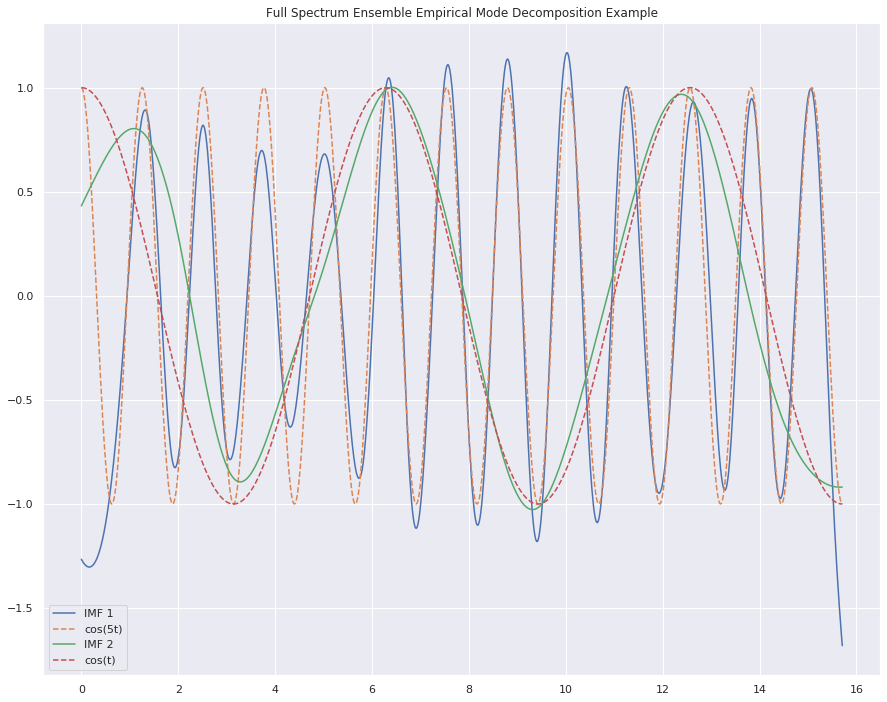

IMF 1 Error 203.79571659850794
IMF 2 Error 167.79282899497343


In [13]:
fseemd_sd = 0.1
imf_1 = np.zeros_like(time_series)
imf_2 = np.zeros_like(time_series)
iterations = 10

for i in range(iterations):

    beta = np.random.random_integers(low=-2, high=2)
    new_time_series = time_series + cn.powerlaw_psd_gaussian(beta, len(time_series)) * sd_time_series * fseemd_sd
    emd = EMD(time=time, time_series=new_time_series)
    imfs = emd.empirical_mode_decomposition(smooth=True, stop_crit_threshold=1, max_imfs=3, verbose=False)[0]

    imf_1 += imfs[2, :]
    imf_2 += imfs[3, :]

plt.title('Full Spectrum Ensemble Empirical Mode Decomposition Example')
plt.plot(time, imf_1 / iterations, label='IMF 1')
plt.plot(time, np.cos(5 * time), '--', label='cos(5t)')
plt.plot(time, imf_2 / iterations, label='IMF 2')
plt.plot(time, np.cos(time), '--', label='cos(t)')
plt.legend(loc='lower left')
plt.show()
print(f'IMF 1 Error {np.sum(np.abs(imf_1 / iterations - np.cos(5 * time)))}')
print(f'IMF 2 Error {np.sum(np.abs(imf_2 / iterations - np.cos(time)))}')

# Compressive Sampling Empirical Mode Decomposition (CSEMD)

# Prepare some functions

In [14]:
def frequency(time_signal, frequency_period, min_frequency, max_frequency):

    end_time = time_signal[-1]  # last time point value
    # time over which frequency changes from minimum frequency to maximum frequency or vice versa
    freq_half_mod = frequency_period / 2  # half period
    time_points = len(time_signal)  # total number of time points
    time_diff = np.diff(time_signal)  # difference between time points
    increments = int(end_time / freq_half_mod)
    increment_length = int(max((time_points - 1) / increments, 1))  # minimum set to 1 as trivial
    new_time_signal = np.zeros_like(time_signal)
    new_time_signal[0] = time_signal[0]

    for i in range(1, time_points):
        if np.mod(i / increment_length, 1) == 0:
            temp_mod = 1
        else:
            temp_mod = np.mod(i / increment_length, 1)
        if ((i - 1) // increment_length) % 2 == 0:
            new_time_signal[i] = new_time_signal[i - 1] + (min_frequency + temp_mod * (max_frequency - min_frequency)) \
                                 * time_diff[i - 1]
        else:
            new_time_signal[i] = new_time_signal[i - 1] + (max_frequency - temp_mod * (max_frequency - min_frequency)) \
                                 * time_diff[i - 1]
    return new_time_signal


def ibst(inst_freq, knot_time, knots):

    output = np.zeros_like(knot_time)
    output[0] = 1

    diff_time = np.diff(knot_time)

    for i in range(1, len(knot_time)):

        output[i] = np.cos(np.sum(inst_freq[:i] * diff_time[:i]))

    basis = Basis(time=knot_time, time_series=output)
    output = basis.basis_function_approximation(knots, knot_time)[0]

    return output


def bst_processing(signal, compression_bool):

    end = signal[-1]
    begin = signal[0]

    A = spfft.idct(np.identity(len(signal)), norm='ortho', axis=0)
    sampling_matrix = np.zeros((np.sum(compression_bool), n))
    row = 0

    ri = np.linspace(0, len(signal)-1, len(signal))
    ri = ri[compression_bool]

    for r in ri:
        sampling_matrix[row, r] = 1
        row += 1

    A = np.matmul(sampling_matrix, A)
    signal = np.matmul(sampling_matrix, signal)

    # do L1 optimization
    vx = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [A * vx == signal]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(verbose=True, solver=cvx.ECOS)

    x = np.array(vx.value)
    sig = spfft.idct(x, norm='ortho', axis=0)

    x_sorted = x.copy()
    x_sorted.sort()
    x_sorted = np.flip(x_sorted)

    indice_storage = np.linspace(0, len(x_sorted) - 1, len(x_sorted))

    indices = []

    level = x_sorted[0]

    for k in x_sorted:

        if k > 0.1 * level:
            indices = np.hstack((indices, indice_storage[x == k]))

    frequency_content = (np.pi / (end - begin)) * indices

    return frequency_content


def imf_construction(signal, compression_bool, knot_time, knots):

    frequencies = bst_processing(signal, compression_bool)

    b_spline_approx = np.zeros_like(signal)

    for f in frequencies:

        b_spline_approx += ibst(f, knot_time, knots)

    return b_spline_approx


def imf_compressive_sampling(signal, signal_time, knots, knots_time, indices, sig_level=0.1, debug=False):

    # establish time domain of frequency
    end_time = signal_time[-1]
    begin_time = signal_time[0]

    # construct basis matrices
    A = spfft.idct(np.identity(len(signal)), norm='ortho', axis=0)
    sampling_matrix = np.zeros((len(indices), len(signal)))
    row = 0
    for r in indices:
        sampling_matrix[row, r] = 1
        row += 1

    # sample matrices
    A = np.matmul(sampling_matrix, A)
    signal = np.matmul(sampling_matrix, signal)

    # do L1 optimization
    vx = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [A * vx == signal]
    prob = cvx.Problem(objective, constraints)
    prob.solve(verbose=True, solver=cvx.ECOS)

    # extract and find largest frequency components
    x = np.array(vx.value)

    if debug:
        plt.plot(range(len(signal_time)) / ((end_time - begin_time) / np.pi), x)
        plt.title('Underlying Frequency Structure')
        # plt.xlim(-3, 8)  # temporary for demonstrative plots
        plt.show()

    x_sorted = x.copy()
    x_sorted.sort()
    x_sorted = np.flip(x_sorted)
    indice_storage = np.linspace(0, len(x_sorted) - 1, len(x_sorted))

    indices = []
    level = x_sorted[0]

    for k in x_sorted:

        if k > sig_level * level:
            indices = np.hstack((indices, indice_storage[x == k]))

    frequency_content = (np.pi / (end_time - begin_time)) * indices

    # construct B-spline approximation
    b_spline_approx = np.zeros_like(knots_time)
    diff_time = np.diff(knots_time)

    magnitude = 0

    for j in frequency_content:

        component = np.zeros_like(b_spline_approx)
        component[0] = 1

        inst_freq = j * np.ones_like(component)[:-1]

        for i in range(1, len(knots_time)):

            component[i] = np.cos(np.sum(inst_freq[:i] * diff_time[:i]))

        basis = Basis(time=knots_time, time_series=component)
        b_spline_approx += \
            (x_sorted[magnitude] / np.sqrt(len(signal_time) / 2)) * basis.basis_function_approximation(knots,
                                                                                                       knots_time)[0]
        magnitude += 1

    return b_spline_approx

# Compressive Sampling Frequency and Reconstruction Plot with Constant Frequency


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.266e-23  -0.000e+00  +2e+03  9e-01  1e-02  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  +7.175e+01  +7.175e+01  +4e+02  5e-01  2e-03  2e-01  2e-01  0.8643  4e-02   0  1  1 |  0  0
 2  +6.979e+01  +6.980e+01  +3e+02  2e-01  2e-03  2e-01  2e-01  0.3470  6e-01   0  1  0 |  0  0
 3  +7.777e+01  +7.778e+01  +2e+02  1e-01  1e-03  1e-01  1e-01  0.4777  5e-01   1  0  0 |  0  0
 4  +8.914e+01  +8.915e+01  +1e+02  4e-02  6e-04  5e-02  6e-02  0.5916  6e-02   1  0  0 |  0  0
 5  +9.585e+01  +9.585e+01  +6e+01  2e-02  3e-04  3e-02  3e-02  0.7565  4e-01   1  0  0 |  0  0
 6  +9.813e+01  +9.813e+01  +3e+01  9e-03  1e-04  1e-02  1e-02  0.6309  2e-01   1  0  1 |  0  0
 7  +9.871e+01  +9.871e+01  +2e+01  5e-03  8e-05  8e-03  8e-03  0.6253  3e-01   1  1  1 |  0  0
 8  +9.930e+01  +9.930e+01  +6e+00  2e-03  3e-

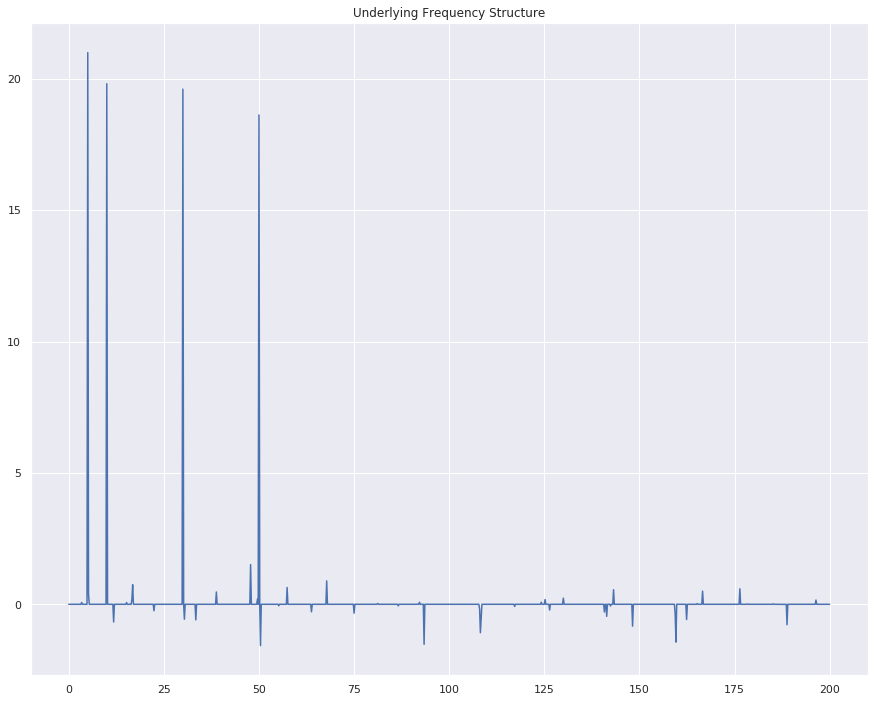

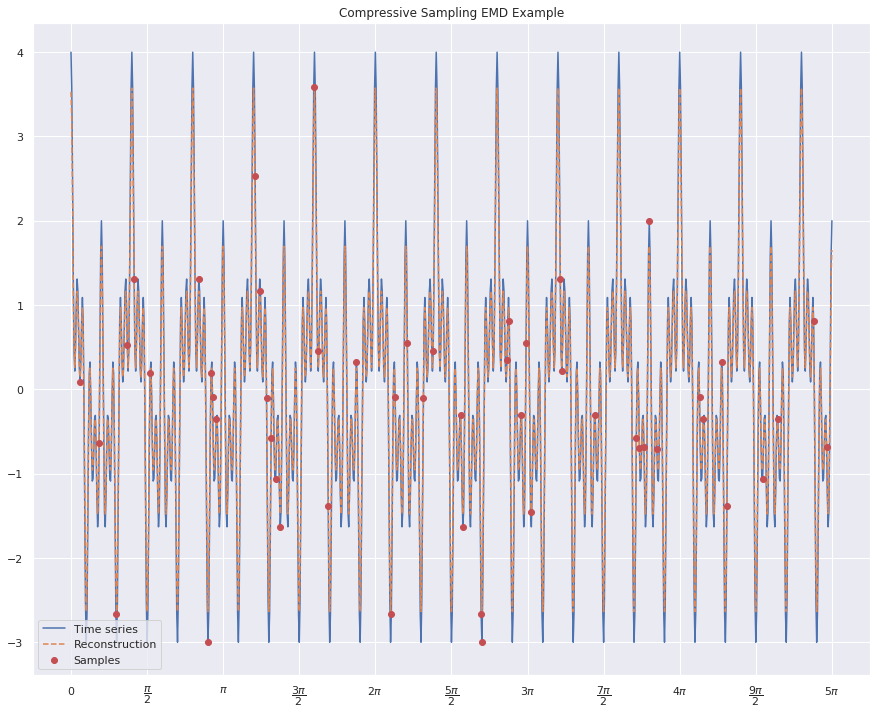

In [16]:
time = np.linspace(0, 5 * np.pi, 1001)
knots = np.linspace(0, 5 * np.pi, 401)

time_series = np.cos(50 * time)
time_series += np.cos(30 * time)
time_series += np.cos(10 * time)
time_series += np.cos(5 * time)

m = 51  # 5% sample
ri = np.random.choice(n, m, replace=False)  # random sample of indices
ri.sort()  # sorting not strictly necessary, but convenient for plotting

reconstructed_time_series = imf_compressive_sampling(time_series, time, knots, time, ri, debug=True)

plt.title('Compressive Sampling EMD Example')
plt.plot(time, time_series, zorder=1, label='Time series')
plt.plot(time, reconstructed_time_series, '--', zorder=2, label='Reconstruction')
plt.scatter(time[ri], time_series[ri], c='r', zorder=3, label='Samples')
plt.legend(loc='lower left')
plt.xticks(x_points, x_names)
plt.show()

# Hilbert Spectrum of Sparsely Sampled Time Series

../AdvEMDpy.py:1191: UserWarning: Recommended knots are subset of knot time points for discontinuity issues.
  warnings.warn('Recommended knots are subset of knot time points for discontinuity issues.')


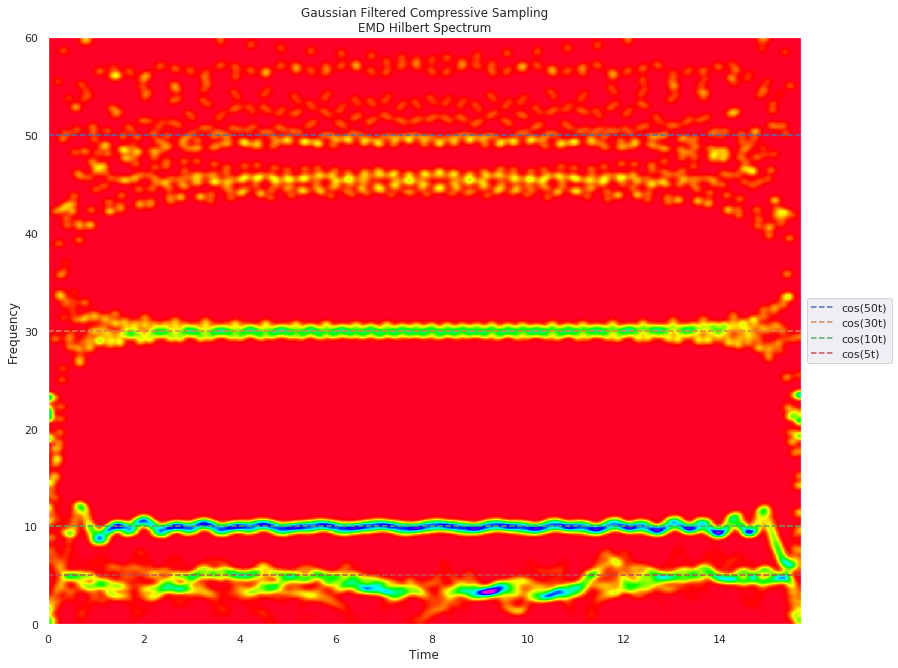

In [17]:
emd = EMD(time=time, time_series=reconstructed_time_series)
imfs, hts, ifs, _, _, dtht, dtif = emd.empirical_mode_decomposition(knots=knots, knot_time=time, smooth=True,
                                                                    stop_crit_threshold=1, dtht=True,
                                                                    dtht_method='fft', verbose=False)

hilbert = hilbert_spectrum(time=time, imf_storage=imfs, ht_storage=dtht, if_storage=dtif, max_frequency=60, plot=False)

z_min, z_max = 0, np.abs(hilbert[2]).max()
fig, ax = plt.subplots()
ax.pcolormesh(hilbert[0], hilbert[1], hilbert[2], cmap='gist_rainbow', vmin=z_min, vmax=z_max)
plt.plot(hilbert[0][0, :], 50 * np.ones_like(hilbert[0][0, :]), '--', label='cos(50t)')
plt.plot(hilbert[0][0, :], 30 * np.ones_like(hilbert[0][0, :]), '--', label='cos(30t)')
plt.plot(hilbert[0][0, :], 10 * np.ones_like(hilbert[0][0, :]), '--', label='cos(10t)')
plt.plot(hilbert[0][0, :], 5 * np.ones_like(hilbert[0][0, :]), '--', label='cos(5t)')
ax.set_title(textwrap.fill('Gaussian Filtered Compressive Sampling EMD Hilbert Spectrum', 40))
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.axis([hilbert[0].min(), hilbert[0].max(), hilbert[1].min(), hilbert[1].max()])

box_0 = ax.get_position()
ax.set_position([box_0.x0 - 0.03, box_0.y0 + 0.05, box_0.width * 0.9, box_0.height * 0.9])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Compressive Sampling Frequency and Reconstruction Plot with Modulated Frequency


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.154e-23  -0.000e+00  +2e+03  9e-01  1e-02  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  +2.127e+01  +2.127e+01  +4e+02  6e-01  2e-03  2e-01  2e-01  0.8650  4e-02   0  1  1 |  0  0
 2  +3.108e+00  +3.113e+00  +3e+02  3e-01  2e-03  2e-01  2e-01  0.2482  7e-01   0  1  0 |  0  0
 3  +2.007e+01  +2.007e+01  +2e+02  1e-01  1e-03  1e-01  1e-01  0.4537  2e-01   0  0  0 |  0  0
 4  +2.532e+01  +2.532e+01  +2e+02  1e-01  9e-04  8e-02  8e-02  0.4259  5e-01   1  0  0 |  0  0
 5  +3.039e+01  +3.040e+01  +6e+01  3e-02  3e-04  3e-02  3e-02  0.9890  3e-01   1  0  0 |  0  0
 6  +3.127e+01  +3.127e+01  +9e+00  5e-03  4e-05  4e-03  4e-03  0.8706  2e-02   1  0  0 |  0  0
 7  +3.175e+01  +3.175e+01  +5e+00  3e-03  3e-05  3e-03  3e-03  0.4515  2e-01   1  1  1 |  0  0
 8  +3.191e+01  +3.191e+01  +4e+00  2e-03  2e-

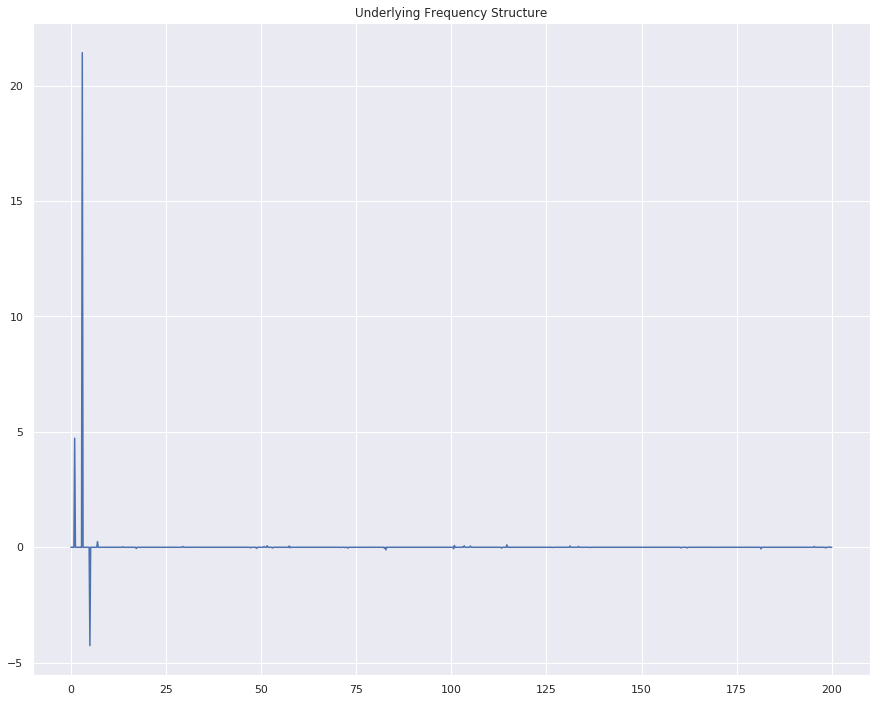

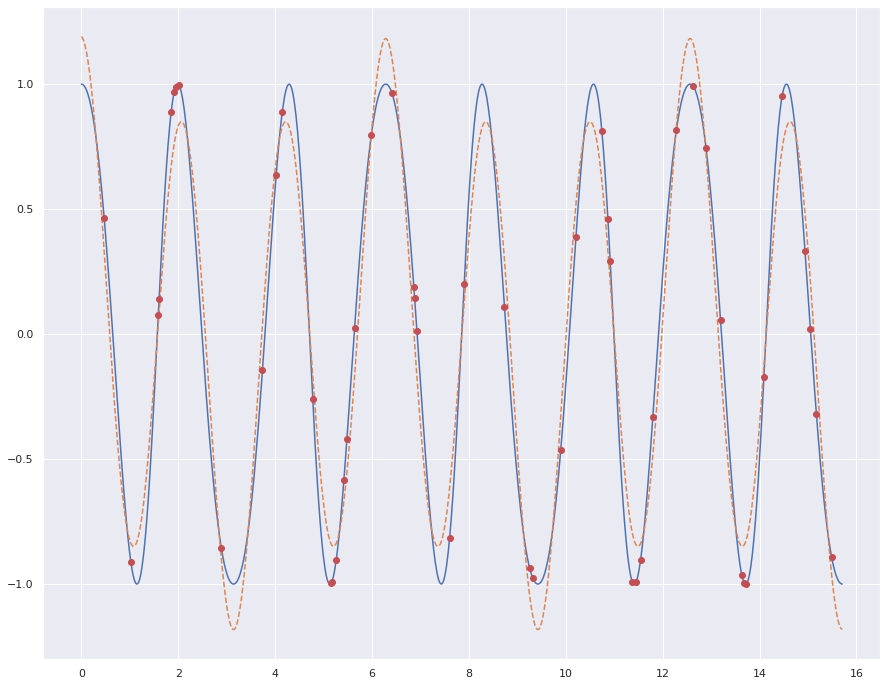

IMF_11 Standard deviation STOPPING CRITERION NOT MET with sd = 114.53
IMF_12 ALL IMF CONDITIONS MET
IMF_21 Standard deviation STOPPING CRITERION NOT MET with sd = 209628.58
IMF_22 ALL IMF CONDITIONS MET


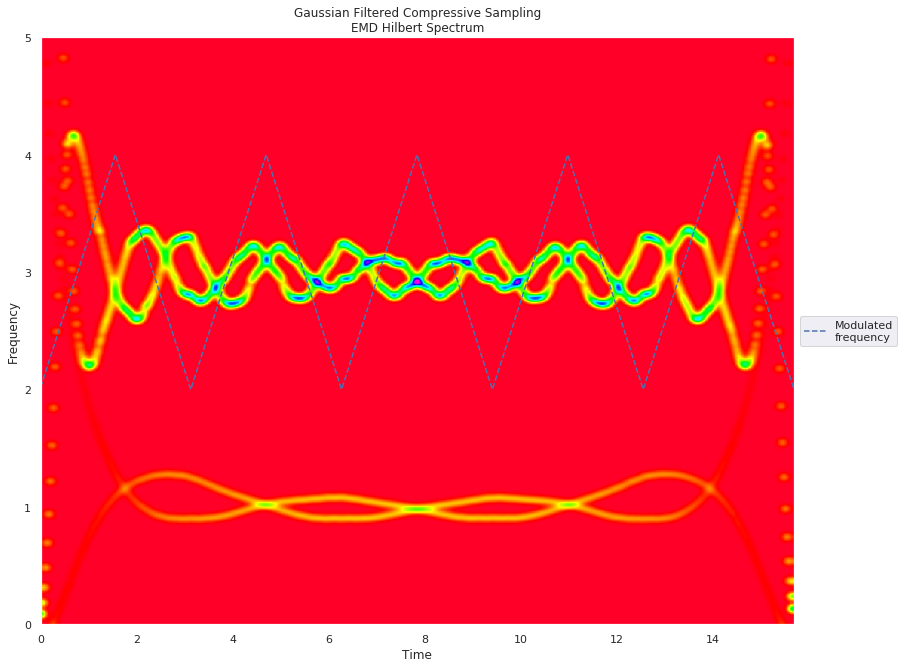

In [19]:
frequency_modulation_period = np.pi
frequency_max = 4
frequency_min = 2
knots = np.linspace(0, 5 * np.pi, 51)

modulated_freq = frequency(time, frequency_modulation_period, frequency_min, frequency_max)

cum_signal_CAMF = np.cos(modulated_freq)

m = 51
ri = np.random.choice(n, m, replace=False)
ri.sort()

temp_freq = imf_compressive_sampling(cum_signal_CAMF, time, knots, time, ri, sig_level=0, debug=True)

plt.plot(time, cum_signal_CAMF, zorder=1)
plt.plot(time, temp_freq, '--', zorder=2)
plt.scatter(time[ri], cum_signal_CAMF[ri], c='r', zorder=3)
plt.show()

emd = EMD(time=time, time_series=temp_freq)
imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots, knot_time=time, smooth=True, stop_crit_threshold=1)[:3]

hilbert = hilbert_spectrum(time=time, imf_storage=imfs, ht_storage=hts, if_storage=ifs, max_frequency=5, plot=False)

z_min, z_max = 0, np.abs(hilbert[2]).max()
fig, ax = plt.subplots()
ax.pcolormesh(hilbert[0], hilbert[1], hilbert[2], cmap='gist_rainbow', vmin=z_min, vmax=z_max)
plt.plot(hilbert[0][0, :], (modulated_freq[:-1] - modulated_freq[1:]) / (time[:-1] - time[1:]),
         '--', label=textwrap.fill('Modulated frequency', 10))
ax.set_title(textwrap.fill('Gaussian Filtered Compressive Sampling EMD Hilbert Spectrum', 40))
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.axis([hilbert[0].min(), hilbert[0].max(), hilbert[1].min(), hilbert[1].max()])

box_0 = ax.get_position()
ax.set_position([box_0.x0 - 0.04, box_0.y0 + 0.05, box_0.width * 0.9, box_0.height * 0.9])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Instantaneous frequency is extremely sensitive to minor errors in time series reconstruction.